# Ridge and Lasso Regression

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (8, 5)
%config InlineBackend.figure_format = 'retina'

# Diabetes dataset

In [3]:
# Meseares of various features and diabetes disease progression for 442 patients.
# Available at https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt
df = pd.read_csv('diabetes.csv')
df

,AGE,SEX,BMI,BP,TC,LDL,HDL,TCH,LTG,GLU,DIS
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


In [5]:
features = list(df.columns.values)
features.remove('DIS')
features

['AGE', 'SEX', 'BMI', 'BP', 'TC', 'LDL', 'HDL', 'TCH', 'LTG', 'GLU']

# Standardized data

In [14]:
X = df.loc[:,'AGE':'GLU'].to_numpy()
y = df['DIS'].to_numpy()

featureMeans = X.mean(axis=0)
featureStd = X.std(axis=0)

Xs = (X - featureMeans) / featureStd

disMean = y.mean()
disStd = y.std()
ys = (y - disMean) / disStd

# Ordinary Least Squares Regression

In [15]:
from sklearn.linear_model import LinearRegression

ols_model = LinearRegression(fit_intercept=False)
ols_model.fit(Xs, ys);

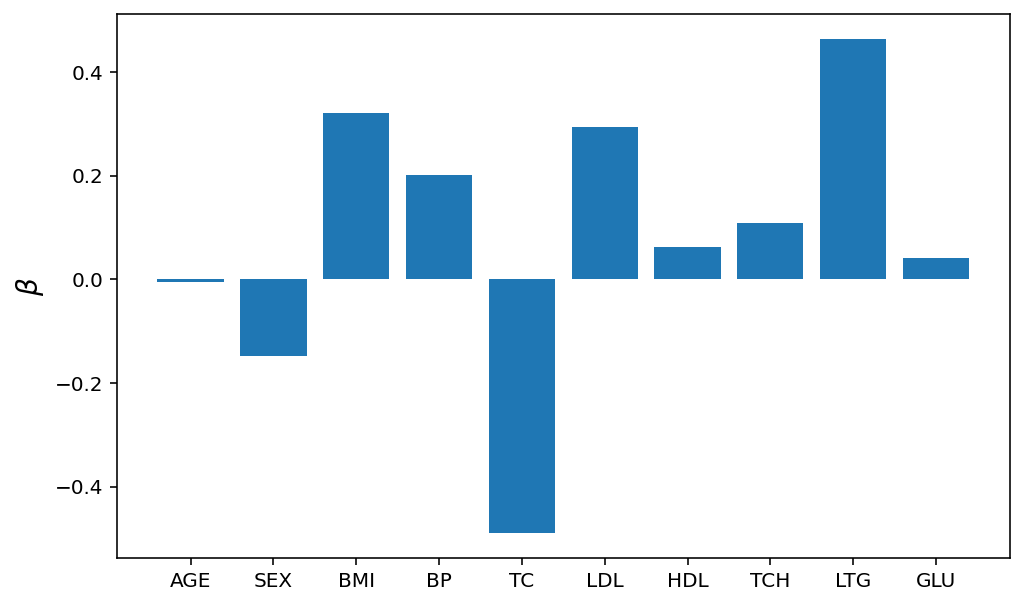

In [16]:
n = len(ols_model.coef_)
plt.bar(range(n), ols_model.coef_)
plt.xticks(range(n), features)
plt.ylabel(r'$\beta$');

### How well did the model do? We can quantify using mean squared error (MSE).

In [27]:
ols_predicted_ys = ols_model.predict(Xs)

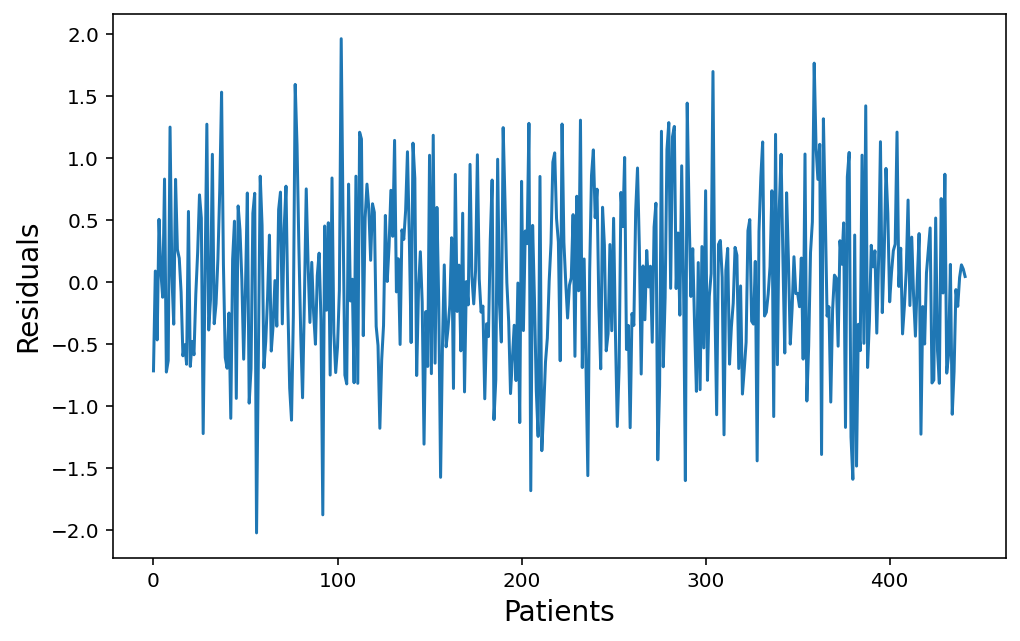

In [28]:
ols_residuals = ys - ols_predicted_ys

plt.plot(ols_residuals)
plt.xlabel('Patients')
plt.ylabel('Residuals');

In [25]:
ols_MSE = np.sum(ols_residuals**2) / len(ols_residuals)

# Ridge Regularization

## Error to be minimized $= SSE + \alpha \sum \limits_j \beta_j^2$

## Let's try $\alpha = 10$.

In [76]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=10, fit_intercept=False)
ridge_model.fit(Xs, ys);

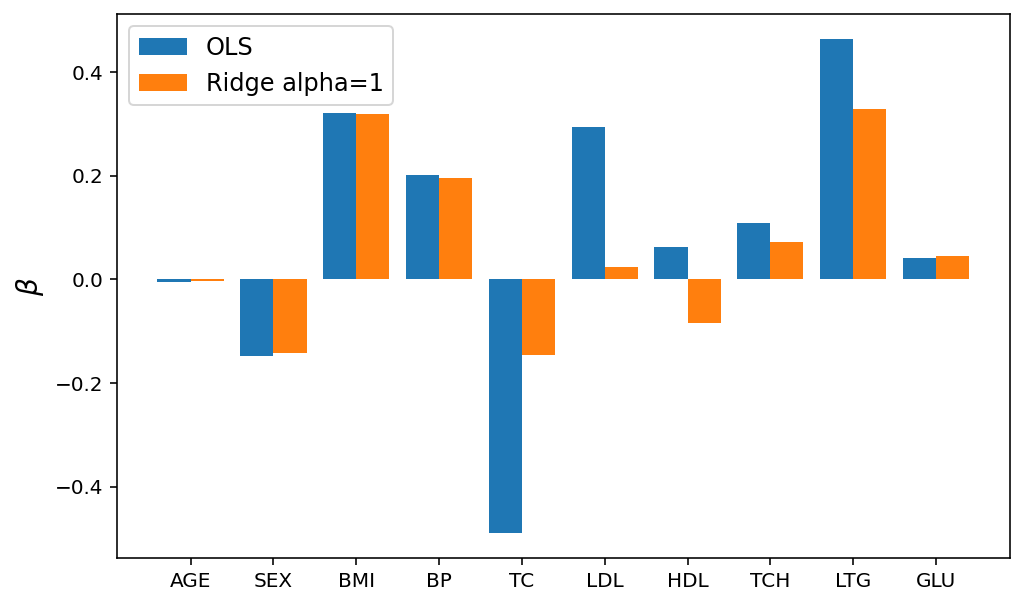

In [77]:
xticks = np.arange(len(features))
plt.bar(xticks-0.2, ols_model.coef_, width=0.4, label='OLS')
plt.bar(xticks+0.2, ridge_model.coef_, width=0.4, label='Ridge alpha=1')
plt.xticks(xticks, features)
plt.ylabel(r'$\beta$')
plt.legend();

### <font color=darkred>What did the Ridge model do to the weights of the highly correlated features TC and LDL as compared to the simple OLS model?</font>

## How well did the Ridge model do?

In [37]:
ridge_MSE = np.sum((ys - ridge_model.predict(Xs))**2) / len(ys)

dfMSE = pd.DataFrame(ols_MSE, columns=['OLS'], index=['MSE'])
dfMSE['Ridge(a=10)'] = ridge_MSE
dfMSE

,OLS,Ridge(a=10)
MSE,0.482252,0.484361


## Ok, but what value should we use for $\alpha$ in Ridge regression?

### What if we generate multiple Ridge models with different valuess of $\alpha$ and pick the one with the lowest mean squared error?

# <font color=darkred>Exercise</font>

1. Fit the diabetes data set using a Ridge model with $\alpha = 0.1$.
2. Compute the MSE for the model fit and add it to the *dfMSE* dataframe for comparison.

## Let's try a bunch of different values for $\alpha$ and see how they do...

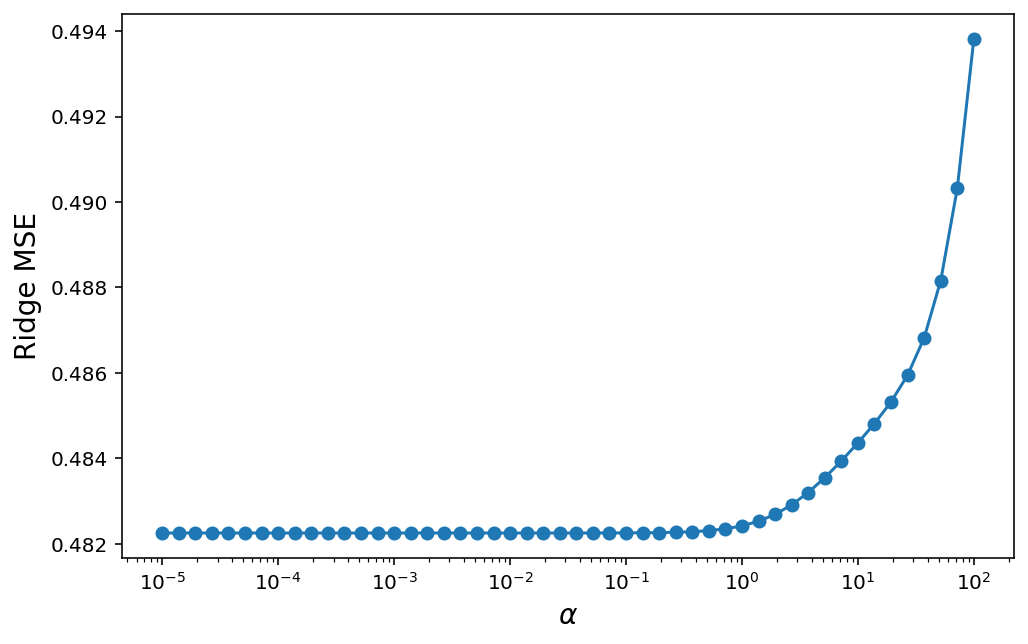

In [62]:
alphas = np.logspace(-5, 2, 50)

mse = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(Xs, ys)
    residuals = ys - model.predict(Xs)
    mse[i] = np.sum(residuals**2) / len(residuals)

plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge MSE');

In [63]:
np.argmin(mse)

0

## Smallest $\alpha$ is best!

## But then absolute best would be $\alpha = 0$, which is just plain old OLS.

## Did ridge regularization not help?

# Training Error vs. Testing Error

![train vs test error](images/train-vs-test-error.png)

# Split the patients into two groups (training and testing)

In [64]:
ntest = 200

Xs_train = Xs[:-ntest, :]
Xs_test = Xs[-ntest:, :]

Xs_train.shape, Xs_test.shape

((242, 10), (200, 10))

In [65]:
ys_train = y[:-ntest]
ys_test = y[-ntest:]

ys_train.shape, ys_test.shape

((242,), (200,))

# Split the patients into two groups (training and testing)

In [66]:
from sklearn.model_selection import train_test_split

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, shuffle=True, test_size=0.5, random_state=1)

Xs_train.shape, Xs_test.shape, ys_train.shape, ys_test.shape

((221, 10), (221, 10), (221,), (221,))

# Now fit the model on the training group ONLY and evaluate the error on the test group ONLY.

In [67]:
alphas = np.logspace(-5, 2, 50)

mse = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(Xs_train, ys_train)
    residuals = ys_test - model.predict(Xs_test)
    mse[i] = np.sum(residuals**2) / len(residuals)

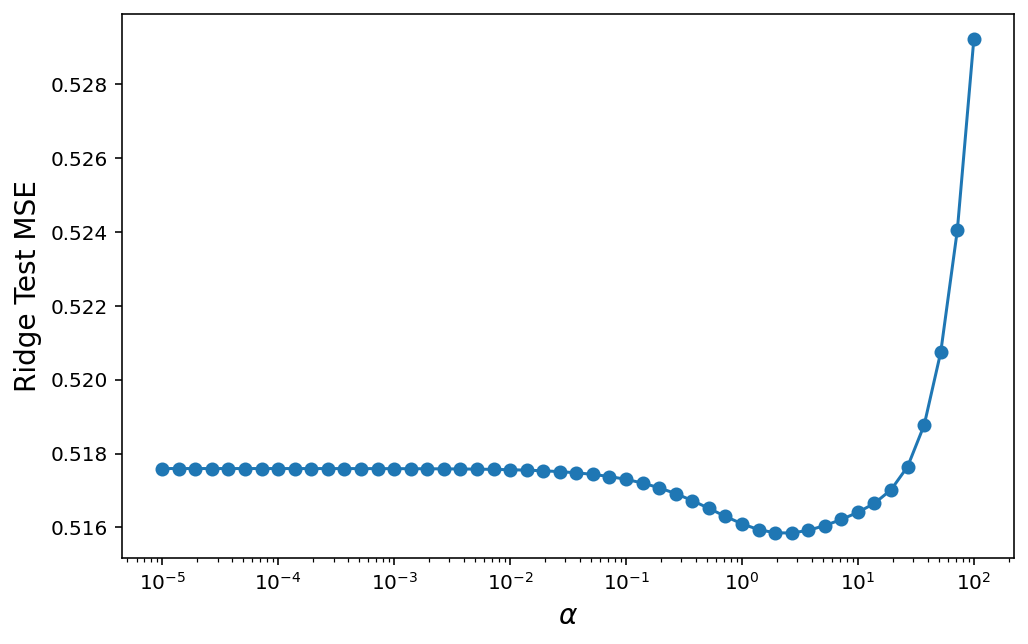

In [69]:
plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge Test MSE');

In [70]:
ind = np.argmin(mse)
bestAlpha = alphas[ind]
bestAlpha

2.682695795279722

In [80]:
ridge_model = Ridge(alpha=bestAlpha, fit_intercept=False)
ridge_model.fit(Xs, ys);

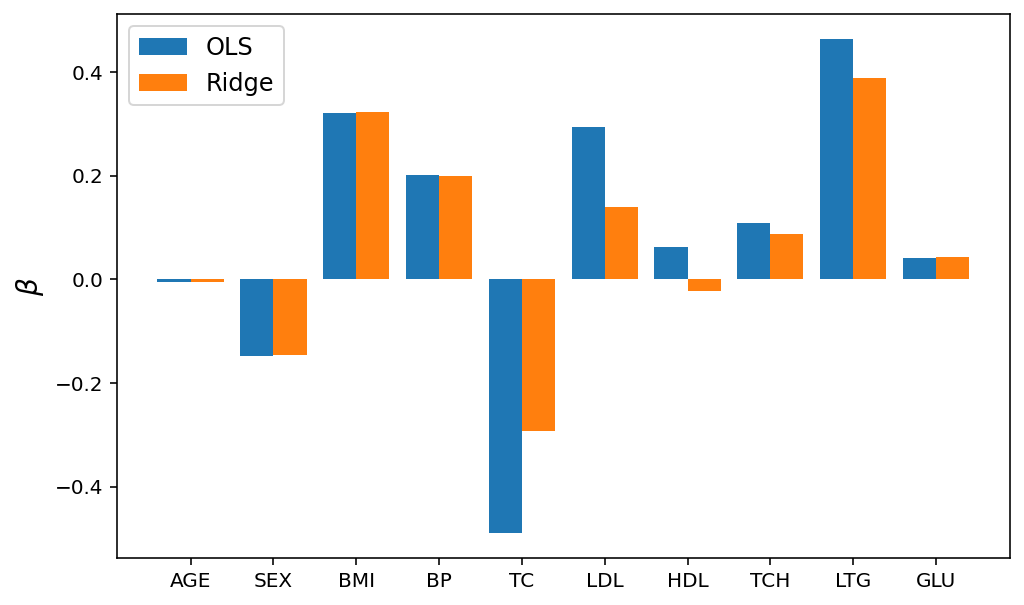

In [81]:
xticks = np.arange(len(features))
plt.bar(xticks-0.2, ols_model.coef_, width=0.4, label='OLS')
plt.bar(xticks+0.2, ridge_model.coef_, width=0.4, label='Ridge')
plt.xticks(xticks, features)
plt.ylabel(r'$\beta$')
plt.legend();

# But the MSE is still worse than for simple OLS!?

In [82]:
ridge_MSE = np.sum((ys - ridge_model.predict(Xs))**2) / len(ys)

dfMSE['Ridge(a=2.68)'] = ridge_MSE
dfMSE

,OLS,Ridge(a=10),Ridge(a=2.68)
MSE,0.482252,0.484361,0.482911


## Why might the Ridge model still be preferred over the OLS model?

## How will each model fair when given new data that the model was not trained on?

# <font color=darkred>Exercise</font>

1. Refit the OLS and Ridge (use best alpha) models using ONLY the training dataset.
2. Compute and compare the MSE for each model using the testing dataset.